## Others

In [ ]:
import pandas as pd
import os

# List of states
states = ['bihar', 'delhi', 'haryana', 'maharashtra', 'punjab', 'telangana', 'up', 'bengal']
language_code = 'en'

# Initialize an empty DataFrame
combined_df = pd.DataFrame()

# Read and concatenate data for all states
for state in states:
    file_path = f"llama_responses/most_frequent_answers_{state}_{language_code}.csv"
    if os.path.exists(file_path):
        state_df = pd.read_csv(file_path)
        state_df['State'] = state  # Add a column for the state
        combined_df = pd.concat([combined_df, state_df], ignore_index=True)
    else:
        print(f"File not found: {file_path}")

# Save the combined DataFrame to a CSV file
combined_df.to_csv(f"llama_responses/most_frequent_answers_allstates_india_{language_code}.csv", index=False)

In [ ]:
import json

# Load input files
with open('data/chosen_cols.json', 'r') as f:
    chosen_cols = json.load(f)

with open('data/qsns_mapping.json', 'r') as f:
    qsns_mapping = json.load(f)

with open('data/questions.json', 'r') as f:
    questions = json.load(f)

# Compute the list of true_qsns
true_qsns = [
    qsn for qsn, val in chosen_cols['chosen_cols'].items()
    if val 
    and qsn in qsns_mapping['2012'].values() 
    and qsn in qsns_mapping['2006'].values() 
    and qsn in questions
]

print(f"Number of matching questions: {len(true_qsns)}")

with open('data/chosen_cols_updated.json', 'r') as f:
    data = json.load(f)
    
for key in data['chosen_cols']:
    if key in true_qsns:
        data['chosen_cols'][key] = True
    else:
        data['chosen_cols'][key] = False

with open('data/chosen_cols_updated.json', 'w') as f:
    json.dump(data, f, indent=4)

Number of matching questions: 91


In [23]:
selected_questions_only_text = {qsn: questions[qsn] for qsn in true_qsns}
with open('data/selected_questions_only.json', 'w') as f:
    json.dump(selected_questions_only_text, f, indent=4)

In [ ]:
from collections import defaultdict

with open('data/themes.json', 'r') as f:
    themes = json.load(f)

# Prepare ranges as tuples (start, end) for easier comparison
theme_ranges = {}
for key, theme_name in themes.items():
    start, end = map(int, key.split('-'))
    theme_ranges[(start, end)] = theme_name

# Count questions per theme
theme_counts = defaultdict(int)

for q in true_qsns:
    # Extract question number as integer
    q_num = int(q[1:]) 
    for (start, end), theme_name in theme_ranges.items():
        if start <= q_num <= end:
            theme_counts[theme_name] += 1
            break 

# Display results
for theme, count in theme_counts.items():
    print(f"{theme}: {count} question(s)")

SOCIAL VALUES, ATTITUDES & STEREOTYPES: 24 question(s)
SOCIAL CAPITAL, TRUST & ORGANIZATIONAL MEMBERSHIP: 23 question(s)
ECONOMIC VALUES: 6 question(s)
SECURITY: 1 question(s)
POSTMATERIALIST INDEX: 6 question(s)
SCIENCE & TECHNOLOGY: 4 question(s)
RELIGIOUS VALUES: 1 question(s)
ETHICAL VALUES AND NORMS: 11 question(s)
POLITICAL CULTURE & POLITICAL REGIMES: 15 question(s)


## Start

In [44]:
year = '2022'
country = 'russia'
language_code = 'en'
filename = '{year}_{country}'.format(year=year, country=country)

In [45]:
import pandas as pd

df = pd.read_excel(f"data/{country}/{year}/{filename}.xlsx")

rows, cols = df.shape
print(f"Rows: {rows}, Columns: {cols}")

/home/dayita/code/wikipedia-bias-2/env/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Rows: 1810, Columns: 396


In [46]:
import json

with open("data/chosen_cols_updated.json", "r") as f:
    data = json.load(f)
    chosen_cols = [colname for colname in data["chosen_cols"] if data["chosen_cols"][colname] is True]
    persona_cols = data["persona_cols"][year].get(country, data["persona_cols"][year]['all'])

## Chosen Persona Features

In [47]:
all_persona_cols = list(persona_cols.values())
grouped = df[all_persona_cols].groupby(all_persona_cols).size().reset_index(name='Counts')
grouped.to_csv(f"data/{country}/{year}/{filename}_persona_groups_{language_code}.csv", index=False)

In [48]:
grouped_cleaned = grouped[grouped["Counts"] >= 4]
grouped_cleaned.to_csv(f"data/{country}/{year}/{filename}_persona_groups_cleaned_{language_code}.csv", index=False)

## Persona Majority Answers

In [38]:
import pandas as pd
import numpy as np

def calculate_majority_answers(year='2022', country='india', language_code='en'):
    persona_filepath = f"data/{country}/{year}/{year}_{country}_persona_groups_cleaned_{language_code}.csv"
    raw_data_filepath = f"data/{country}/{year}/{year}_{country}.xlsx"
    output_filepath = f"data/{country}/{year}/{year}_{country}_majority_answers_by_persona_{language_code}.csv"

    personas_df = pd.read_csv(persona_filepath)
    raw_data_df = pd.read_excel(raw_data_filepath)

    # Identify the demographic columns to group by
    demographic_columns = personas_df.columns.drop('Counts').tolist()

    # Identify question columns (contain ':' but are not demographics)
    question_columns = [col for col in raw_data_df.columns if ':' in col and col not in demographic_columns]

    print(f"Grouping by {len(demographic_columns)} demographic columns.")
    print(f"Analyzing {len(question_columns)} question columns.")

    # Ensure both DataFrames have consistent types for grouping columns
    for col in demographic_columns:
        personas_df[col] = personas_df[col].astype(str)
        raw_data_df[col] = raw_data_df[col].astype(str)

    # Function to compute majority value (mode)
    def get_majority(series):
        modes = series.mode()
        return modes[0] if not modes.empty else np.nan

    # Create aggregation mapping
    agg_dict = {col: get_majority for col in question_columns}

    # Replace values
    print("Calculating majority answers for each persona group...")
    majority_answers_df = raw_data_df.groupby(demographic_columns).agg(agg_dict).reset_index()

    # Merge results
    final_df = pd.merge(personas_df, majority_answers_df, on=demographic_columns, how='left')
    
    for col in question_columns:
        final_df[col] = final_df[col].astype(str).apply(lambda x: ' '.join(x.split()))

    # Save final result
    final_df.to_csv(output_filepath, index=False)
    print(f"\nSuccessfully created output file at: {output_filepath}")

    return final_df

In [ ]:
result_df = calculate_majority_answers(year=year, country=country, language_code=language_code)

/home/dayita/code/wikipedia-bias-2/env/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Grouping by 10 demographic columns.
Analyzing 386 question columns.
Calculating majority answers for each persona group...

Successfully created output file at: data/russia/2022/2022_russia_majority_answers_by_persona_en.csv


## Chosen Columns

In [ ]:
from IPython.display import display
import pandas as pd

def is_chosen_col(col):
    qsn = col.split(':')[0].strip()
    return qsn in chosen_cols

chosen_col_names = list(persona_cols.values()) + [col for col in df.columns if is_chosen_col(col)]
chosen = df[chosen_col_names]
chosen.to_csv(f"data/{country}/{year}/{filename}_cleaned_{language_code}.csv", index=False)

rows, cols = chosen.shape
print(f"Rows: {rows}, Columns: {cols}")

Rows: 2500, Columns: 10


## Charts

In [65]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.patches as mpatches

# Load questions JSON
with open("data/questions.json", "r") as f:
    qsns = json.load(f)

# Collect distinct option sets
option_sets = {}
for qid, qdata in qsns.items():
    opts = tuple(qdata.get("options", []))
    option_sets.setdefault(opts, []).append((qid, qdata))

print("Found", len(option_sets), "distinct option sets")

# Directory for plots
os.makedirs("plots_by_region_variation", exist_ok=True)

# Columns: only Region varies, others are fixed
fixed_cols = [
    'Q260: Sex',
    'X003R: Age recoded (6 intervals)',
    'Q275R: Highest educational level: Respondent (recoded into 3 groups)'
]

region_col = 'N_REGION_ISO: Region ISO 3166-2'

# Get all unique fixed combinations
fixed_combinations = chosen[fixed_cols].drop_duplicates()

for idx, fixed_vals in fixed_combinations.iterrows():
    # Filter df for this fixed combination
    mask = (chosen[fixed_cols] == fixed_vals.values).all(axis=1)
    subset = chosen[mask].copy()
    if subset.empty:
        continue

    # Create GroupKey: only Region varies
    subset["GroupKey"] = subset[region_col].astype(str)

    for i, (opts, qlist) in enumerate(option_sets.items(), start=1):
        option_to_num = {opt: j for j, opt in enumerate(opts)}
        heatmap_data = pd.DataFrame(index=[q[0] for q in qlist])

        for qid, qdata in qlist:
            matching_cols = [c for c in subset.columns if c.startswith(f"{qid}:")]
            if not matching_cols:
                continue
            col = matching_cols[0]

            # Group by Region only
            mode_per_group = subset.groupby("GroupKey")[col].agg(
                lambda x: x.value_counts().idxmax() if len(x.dropna()) else None
            )

            numeric_mode = mode_per_group.map(option_to_num)
            heatmap_data.loc[qid, numeric_mode.index] = numeric_mode.values

        heatmap_data = heatmap_data.dropna(how="all", axis=0).dropna(how="all", axis=1)
        if heatmap_data.empty:
            continue

        # Prepare figure
        plt.figure(figsize=(18, 8))
        ax = sns.heatmap(
            heatmap_data.astype(float),
            annot=False,
            cmap="YlGnBu",
            cbar=False
        )

        # Title with fixed column values
        fixed_desc = " | ".join([f"{col}: {val}" for col, val in zip(fixed_cols, fixed_vals)])
        plt.title(f"Most Voted Option per Question and Region\nFixed: {fixed_desc}\nOption Set {i}")
        plt.xlabel("Region")
        plt.ylabel("Question ID")
        plt.xticks(rotation=45, ha="right")

        # Legend
        cmap = plt.cm.get_cmap("YlGnBu", len(opts))
        legend_handles = [mpatches.Patch(color=cmap(j / (len(opts)-1)), label=f"{j}: {opt}")
                          for j, opt in enumerate(opts)]
        plt.legend(
            handles=legend_handles,
            title="Options",
            bbox_to_anchor=(1.05, 1),
            loc="upper left"
        )

        plt.tight_layout()
        # Save plot with fixed combination in filename
        fixed_str = "_".join([str(val).replace("/", "-") for val in fixed_vals])
        plt.savefig(f"plots_by_group/heatmap_option_set_{i}_fixed_{fixed_str}.png", dpi=300, bbox_inches="tight")
        plt.close()


Found 42 distinct option sets


/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/3831621480.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", len(opts))
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/3831621480.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", len(opts))
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/3831621480.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` in

Comparing Different N_REGION_ISO: Region ISO 3166-2 Options


/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/2936379874.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/2936379874.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/2936379874.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/2936379874.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_7

KeyboardInterrupt: 

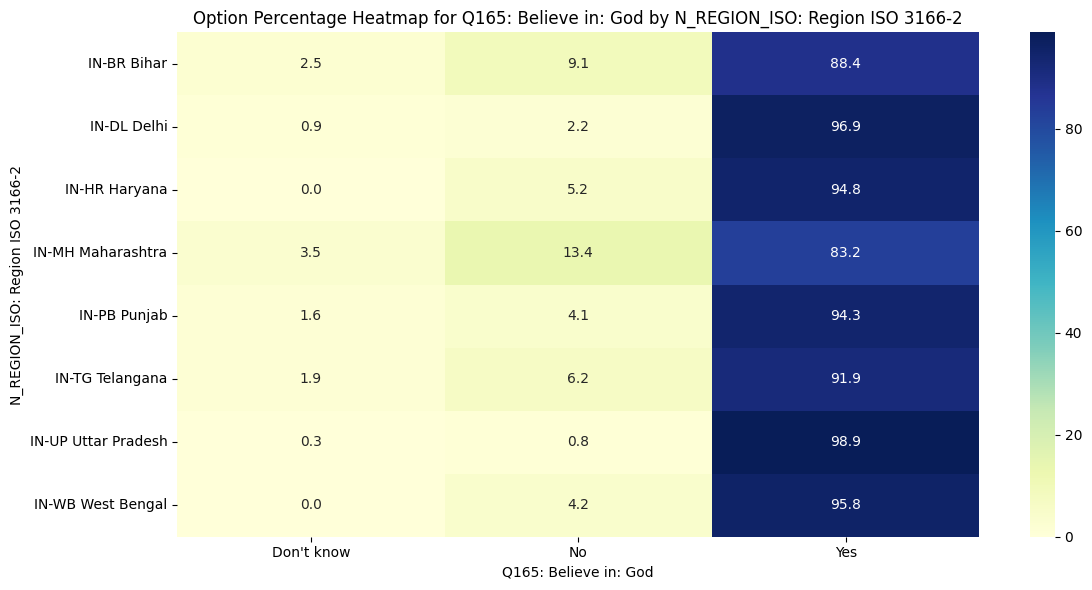

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

os.makedirs("plots3", exist_ok=True)

def sanitize_filename(name: str) -> str:
    return re.sub(r'[^A-Za-z0-9_\-]', '_', name)

cols_to_show = [col for col in chosen.columns if is_chosen_col(col)]
cols_to_compare = [
    'N_REGION_ISO: Region ISO 3166-2'
]

for persona_value in cols_to_compare:
    print(f"Comparing Different {persona_value} Options")

    for col in cols_to_show:
        if col == persona_value:
            continue

        ct = chosen.groupby(persona_value)[col].value_counts().unstack(fill_value=0)
        ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

        plt.figure(figsize=(12, 6))
        sns.heatmap(ct_pct, annot=True, fmt=".1f", cmap="YlGnBu")
        plt.title(f'Option Percentage Heatmap for {col} by {persona_value}')
        plt.xlabel(col)
        plt.ylabel(persona_value)
        plt.tight_layout()

        safe_col = sanitize_filename(col)
        safe_persona = sanitize_filename(persona_value)
        filename = f"plots3/heatmap_{safe_col}_by_{safe_persona}.png"

        plt.savefig(filename, dpi=300)
        plt.close()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

os.makedirs("plots2", exist_ok=True)

df1 = pd.read_csv("data/2022_cleaned.csv")
df1["Country"] = "India"

df2 = pd.read_csv("data/2022_russia_cleaned.csv")
df2["Country"] = "Russia"

df3 = pd.read_csv("data/2022_US_cleaned.csv")
df3["Country"] = "US"

df4 = pd.read_csv("data/2022_japan_cleaned.csv")
df4["Country"] = "Japan"

df5 = pd.read_csv("data/2022_australia_cleaned.csv")
df5["Country"] = "Australia"

df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

def sanitize_filename(name: str) -> str:
    return re.sub(r'[^A-Za-z0-9_\-]', '_', name)

cols_to_show = [col for col in df.columns if is_chosen_col(col)]
cols_to_compare = [
    'Country',
    # 'N_REGION_ISO: Region ISO 3166-2',
    # 'H_URBRURAL: Urban-Rural',
    # 'Q260: Sex',
    # 'X003R: Age recoded (6 intervals)',
    # 'Q272: Language at home',
    # 'Q273: Marital status',
    # 'Q275R: Highest educational level: Respondent (recoded into 3 groups)',
    # 'Q279: Employment status',
    # 'Q287: Social class (subjective)',
    # 'Q289: Religious denominations - major groups'
]

for persona_value in cols_to_compare:
    print(f"Comparing Different {persona_value} Options")

    for col in cols_to_show:
        if col == persona_value:
            continue

        ct = df.groupby(persona_value)[col].value_counts().unstack(fill_value=0)
        ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

        plt.figure(figsize=(12, 6))
        sns.heatmap(ct_pct, annot=True, fmt=".1f", cmap="YlGnBu")
        plt.title(f'Option Percentage Heatmap for {col} by {persona_value}')
        plt.xlabel(col)
        plt.ylabel(persona_value)
        plt.tight_layout()

        safe_col = sanitize_filename(col)
        safe_persona = sanitize_filename(persona_value)
        filename = f"plots2/heatmap_{safe_col}_by_{safe_persona}.png"

        plt.savefig(filename, dpi=300)
        plt.close()

Comparing Different Country Options
